### `Implied Volatility Smile`

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.optimize import least_squares
from scipy import interpolate


In [2]:
# define balck-scholes model
def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


In [3]:
SPX = pd.read_csv("SPX_options.csv")
zero_rate = pd.read_csv("zero_rates_20201201.csv")

In [4]:
df = pd.DataFrame()

In [5]:
SPX["date"] = pd.to_datetime(SPX.date, format="%Y%m%d")
SPX["exdate"] = pd.to_datetime(SPX.exdate, format="%Y%m%d")

In [6]:
# getting time periods
SPX["Time"] = (SPX.exdate - SPX.date).dt.days

In [7]:
# interpolate for rates
x = zero_rate['days']
y = zero_rate['rate']
y_inter = interpolate.interp1d(x,y)

SPX["rate"] = y_inter(SPX["Time"])/100

In [8]:
# define implied vol funtion under black scholes model
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff == 'C'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff == 'P'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol



# Data for `SPX` option

### T = 17, 45, 80

In [9]:
SPX_S = 3662.45

In [10]:
# forward prices for each time period
SPX_F17 = np.exp(SPX["rate"].unique()[0]*17/365)* SPX_S
SPX_F45 = np.exp(SPX["rate"].unique()[1]*45/365)* SPX_S
SPX_F80 = np.exp(SPX["rate"].unique()[2]*80/365)* SPX_S

In [11]:
# data for each time period

T_17 = SPX[SPX.Time == 17]
T_17["mid_price"] = (T_17["best_bid"] + T_17["best_offer"])/2
C_17 = T_17[T_17.cp_flag == "C"]
P_17 = T_17[T_17.cp_flag == "P"]

T_45 = SPX[SPX.Time == 45]
T_45["mid_price"] = (T_45["best_bid"] + T_45["best_offer"])/2
C_45 = T_45[T_45.cp_flag == "C"]
P_45 = T_45[T_45.cp_flag == "P"]

T_80 = SPX[SPX.Time == 80]
T_80["mid_price"] = (T_80["best_bid"] + T_80["best_offer"])/2
C_80 = T_80[T_80.cp_flag == "C"]
P_80 = T_80[T_80.cp_flag == "P"]

/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/2527777829.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_17["mid_price"] = (T_17["best_bid"] + T_17["best_offer"])/2
/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/2527777829.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_45["mid_price"] = (T_45["best_bid"] + T_45["best_offer"])/2
/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/2527777829.py:14: SettingWithCopyWarning: 
A value is trying to be 

In [12]:
df_P17 = P_17[P_17.strike_price/1000 < SPX_F17][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]
df_C17 = C_17[C_17.strike_price/1000 > SPX_F17][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]

df_P45 = P_45[P_45.strike_price/1000 < SPX_F45][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]
df_C45 = C_45[C_45.strike_price/1000 > SPX_F45][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]

df_P80 = P_80[P_80.strike_price/1000 < SPX_F80][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]
df_C80 = C_80[C_80.strike_price/1000 > SPX_F80][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]

In [13]:
df_17 = pd.concat([df_P17, df_C17], ignore_index=True)
df_17.strike_price = df_17.strike_price/1000

df_45 = pd.concat([df_P45, df_C45], ignore_index=True)
df_45.strike_price = df_45.strike_price/1000

df_80 = pd.concat([df_P80, df_C80], ignore_index=True)
df_80.strike_price = df_80.strike_price/1000

In [14]:
IV_17 = []
r_17 = SPX["rate"].unique()[0]
T_17 = 17/365

IV_45 = []
r_45 = SPX["rate"].unique()[1]
T_45 = 45/365

IV_80 = []
r_80 = SPX["rate"].unique()[2]
T_80 = 80/365

In [15]:
# implied vol for t= 17

for i in range(0,len(df_17)):
    IV_17.append(impliedVolatility(SPX_S, df_17.strike_price[i], r_17, df_17.mid_price[i], T_17, df_17.cp_flag[i]))
    

In [16]:
# implied vol for t= 45

for i in range(0,len(df_45)):
    IV_45.append(impliedVolatility(SPX_S, df_45.strike_price[i], r_45, df_45.mid_price[i], T_45, df_45.cp_flag[i]))

In [17]:
# implied vol for t= 80

for i in range(0,len(df_80)):
    IV_80.append(impliedVolatility(SPX_S, df_80.strike_price[i], r_80, df_80.mid_price[i], T_80, df_80.cp_flag[i]))

In [18]:
df_17["IV"] = IV_17
df_45["IV"] = IV_45
df_80["IV"] = IV_80

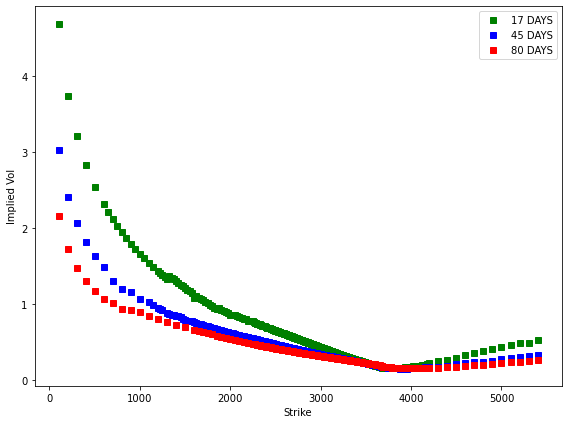

In [19]:
# volatility smile for market data

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_17["strike_price"], df_17["IV"], 'gs', label= "17 DAYS")
plt.plot(df_45["strike_price"], df_45["IV"], 'bs', label= "45 DAYS")
plt.plot(df_80["strike_price"], df_80["IV"], 'rs', label= "80 DAYS")
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()


## Diffused diffusion model calibration for SPX data

In [20]:
# define model

def DisplacedDiffusion_Call(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    d1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    d2 = d1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(F/beta*norm.cdf(d1) - ((1-beta)/beta*F + K)*norm.cdf(d2))

def DisplacedDiffusion_Put(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    d1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    d2 = d1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-d2) - F/beta*norm.cdf(-d1))


def DisplacedDiffusion(S, K, r, sigma, T, beta, payoff):
    if (payoff == 'C'):
        DisplacedDiffusion_Call(S, K, r, sigma, T, beta)
        
    elif (payoff == 'P'):
        DisplacedDiffusion_Put(S, K, r, sigma, T, beta)


In [21]:
# define calibration

def diffusedcalibration(x, strikes, prices, S, r, T, payoff):
    err = 0.0
    for i, prices in enumerate(prices):
        if (payoff[i] == "C"):
            err += (prices -  DisplacedDiffusion_Call(S, strikes[i], r, x[0], T, x[1]))**2
        
        elif (payoff[i] == 'P'):
            err += (prices -  DisplacedDiffusion_Put(S, strikes[i], r, x[0], T, x[1]))**2
    return err

In [22]:
# calibration for t = 17

initialGuess = [0.1, 0.2]

res = least_squares(lambda x: diffusedcalibration(x,
                                             df_17["strike_price"],
                                             df_17["mid_price"],
                                             SPX_S,
                                             r_17,
                                             17/365,
                                             df_17["cp_flag"].values),
                    initialGuess)

s_ddm = res.x[0]
b_ddm = res.x[1]

print('Calibrated DDM model parameters: sigma = %.6f, beta = %.6f' % (s_ddm, b_ddm))

Calibrated DDM model parameters: sigma = 0.183446, beta = 0.173406


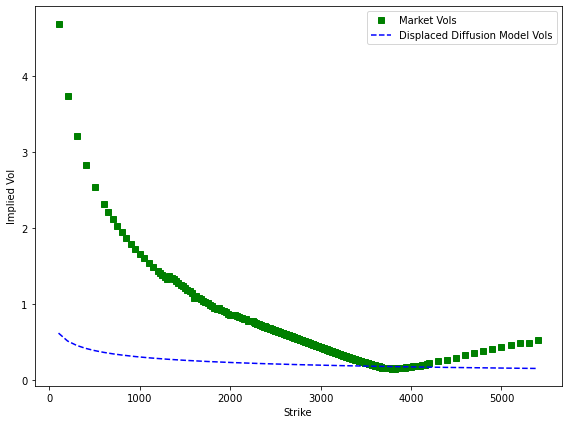

In [23]:
# vol smile for t = 17

ddmvols = []
for i in range(len(df_17)):
    
    if (df_17["cp_flag"][i] == "C"):
        price_ddm = DisplacedDiffusion_Call(SPX_S, df_17["strike_price"][i], r_17, s_ddm, T_17, b_ddm) 
        vol_ddm = impliedVolatility(SPX_S, df_17["strike_price"][i], r_17, price_ddm, T_17, "C")
        
    elif (df_17["cp_flag"][i] == "P"):
        price_ddm = DisplacedDiffusion_Put(SPX_S, df_17["strike_price"][i], r_17, s_ddm, T_17, b_ddm) 
        vol_ddm = impliedVolatility(SPX_S, df_17["strike_price"][i], r_17, price_ddm, T_17, "P")
        
    
    ddmvols.append(vol_ddm)

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_17["strike_price"], df_17["IV"], 'gs', label='Market Vols')
plt.plot(df_17["strike_price"], ddmvols, 'b--', label='Displaced Diffusion Model Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

In [24]:
# calibration for t = 45

initialGuess = [0.1, 0.2]

res = least_squares(lambda x: diffusedcalibration(x,
                                             df_45["strike_price"],
                                             df_45["mid_price"],
                                             SPX_S,
                                             r_45,
                                             45/365,
                                             df_45["cp_flag"].values),
                    initialGuess)

s_ddm = res.x[0]
b_ddm = res.x[1]

print('Calibrated DDM model parameters: sigma = %.6f, beta = %.6f' % (s_ddm, b_ddm))

Calibrated DDM model parameters: sigma = 0.194903, beta = 0.143831


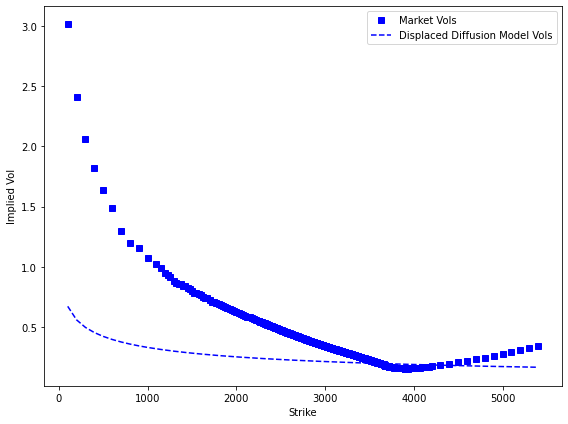

In [25]:
# vol smile for t = 45

ddmvols = []
for i in range(len(df_45)):
    
    if (df_45["cp_flag"][i] == "C"):
        price_ddm = DisplacedDiffusion_Call(SPX_S, df_45["strike_price"][i], r_45, s_ddm, T_45, b_ddm) 
        vol_ddm = impliedVolatility(SPX_S, df_45["strike_price"][i], r_45, price_ddm, T_45, "C")
        
    elif (df_45["cp_flag"][i] == "P"):
        price_ddm = DisplacedDiffusion_Put(SPX_S, df_45["strike_price"][i], r_45, s_ddm, T_45, b_ddm) 
        vol_ddm = impliedVolatility(SPX_S, df_45["strike_price"][i], r_45, price_ddm, T_45, "P")
        
    
    ddmvols.append(vol_ddm)

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_45["strike_price"], df_45["IV"], 'bs', label='Market Vols')
plt.plot(df_45["strike_price"], ddmvols, 'b--', label='Displaced Diffusion Model Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

In [26]:
# calibration for t = 45

initialGuess = [0.1, 0.2]

res = least_squares(lambda x: diffusedcalibration(x,
                                             df_80["strike_price"],
                                             df_80["mid_price"],
                                             SPX_S,
                                             r_80,
                                             80/365,
                                             df_80["cp_flag"].values),
                    initialGuess)

s_ddm = res.x[0]
b_ddm = res.x[1]

print('Calibrated DDM model parameters: sigma = %.6f, beta = %.6f' % (s_ddm, b_ddm))

Calibrated DDM model parameters: sigma = 0.201396, beta = 0.111717


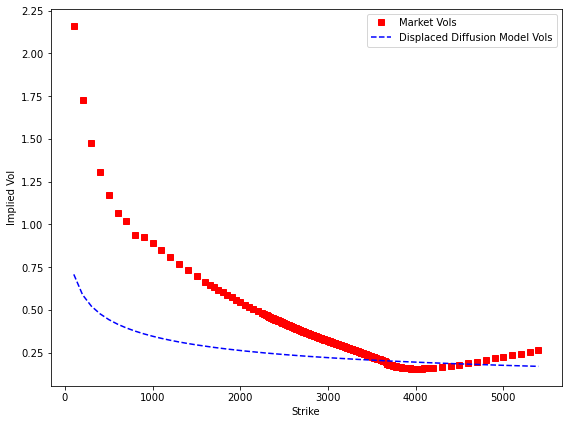

In [27]:
# vol smile for t = 45

ddmvols = []
for i in range(len(df_80)):
    
    if (df_80["cp_flag"][i] == "C"):
        price_ddm = DisplacedDiffusion_Call(SPX_S, df_80["strike_price"][i], r_80, s_ddm, T_80, b_ddm) 
        vol_ddm = impliedVolatility(SPX_S, df_80["strike_price"][i], r_80, price_ddm, T_80, "C")
        
    elif (df_80["cp_flag"][i] == "P"):
        price_ddm = DisplacedDiffusion_Put(SPX_S, df_80["strike_price"][i], r_80, s_ddm, T_80, b_ddm) 
        vol_ddm = impliedVolatility(SPX_S, df_80["strike_price"][i], r_80, price_ddm, T_80, "P")
        
    
    ddmvols.append(vol_ddm)

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_80["strike_price"], df_80["IV"], 'rs', label='Market Vols')
plt.plot(df_80["strike_price"], ddmvols, 'b--', label='Displaced Diffusion Model Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

## SABR model for SPX data

In [28]:
# define model

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [29]:
# define calibration

from scipy.optimize import least_squares

beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

In [30]:
#sabrcalibration(initialGuess, df.strike_price, df.IV, SPX_F, 17/365)

In [31]:
# calibration for t = 17

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_17.strike_price,
                                              df_17.IV,
                                              SPX_F17,
                                              T_17),
                    initialGuess)

/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/1833376684.py:14: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/1833376684.py:14: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


In [32]:
# results for t = 17

alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


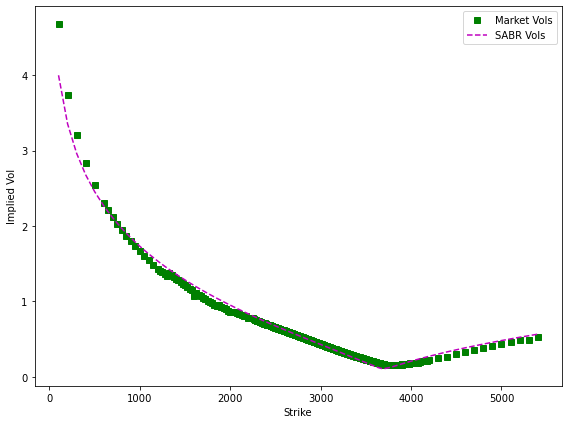

In [33]:
# vol smile for t = 17

sabrvols = []
for K in df_17.strike_price:
    sabrvols.append(SABR(SPX_F17, K, T_17, alpha, beta, rho, nu))

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_17.strike_price, df_17.IV, 'gs', label='Market Vols')
plt.plot(df_17.strike_price, sabrvols, 'm--', label='SABR Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

In [34]:
# calibration for t = 45
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_45.strike_price,
                                              df_45.IV,
                                              SPX_F45,
                                              T_45),
                    initialGuess)

/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/1833376684.py:14: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/1833376684.py:14: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


In [35]:
# results for t = 45

alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


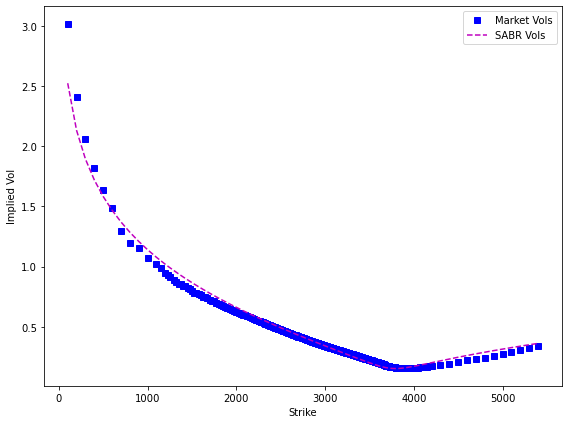

In [36]:
# vol smile for t = 45

sabrvols = []
for K in df_45.strike_price:
    sabrvols.append(SABR(SPX_F45, K, T_45, alpha, beta, rho, nu))

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_45.strike_price, df_45.IV, 'bs', label='Market Vols')
plt.plot(df_45.strike_price, sabrvols, 'm--', label='SABR Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

In [37]:
# calibration for t = 80
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_80.strike_price,
                                              df_80.IV,
                                              SPX_F80,
                                              T_80),
                    initialGuess)

In [38]:
# results for t = 80

alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


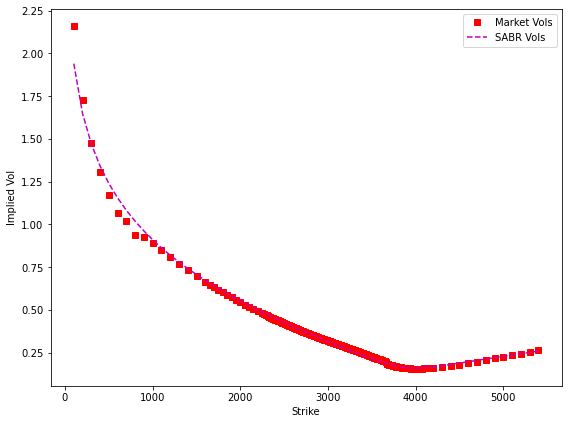

In [39]:
# vol smile for t = 80

sabrvols = []
for K in df_80.strike_price:
    sabrvols.append(SABR(SPX_F80, K, T_80, alpha, beta, rho, nu))

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_80.strike_price, df_80.IV, 'rs', label='Market Vols')
plt.plot(df_80.strike_price, sabrvols, 'm--', label='SABR Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

# Data for `SPY` option

In [40]:
# Define american and european option binomial

import array


def american_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
            put_values[i] = max(put_values[i], (K-prices[i]))
    return put_values[0]


def european_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
    return put_values[0]


def american_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    prices = array.array('d', (0 for i in range(0, steps+1)))

    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]
            call_values[i] = max(call_values[i], 1.0*(prices[i]-K))

    return call_values[0]


def european_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    # price of underlying
    prices = array.array('d', (0 for i in range(0, steps+1)))

    # fill in the endnodes
    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]

    return call_values[0]

In [41]:
SPY = pd.read_csv("SPY_options.csv")
zero_rate = pd.read_csv("zero_rates_20201201.csv")

In [42]:
df = pd.DataFrame()

In [43]:
SPY["date"] = pd.to_datetime(SPY.date, format="%Y%m%d")
SPY["exdate"] = pd.to_datetime(SPY.exdate, format="%Y%m%d")

In [44]:
SPY["Time"] = (SPY.exdate - SPY.date).dt.days
SPY["rate"] = y_inter(SPY["Time"])/100

In [45]:
# Implied vol for american option

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff == 'C'):
            impliedVol = brentq(lambda x: price -
                                 american_call(S, K, r, x, T,150),
                                1e-12, 10.0)
        elif (payoff == 'P'):
            impliedVol = brentq(lambda x: price -
                                american_put(S, K, r, x, T,150),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol




### T = 17, 45, 80

In [46]:
SPY_S = 366.02

In [47]:
SPY_F17 = np.exp(SPY["rate"].unique()[0]*17/365)* SPY_S
SPY_F45 = np.exp(SPY["rate"].unique()[1]*45/365)* SPY_S
SPY_F80 = np.exp(SPY["rate"].unique()[2]*80/365)* SPY_S

In [48]:
# Data split for SPY 

T_17 = SPY[SPY.Time == 17]
T_17["mid_price"] = (T_17["best_bid"] + T_17["best_offer"])/2
C_17 = T_17[T_17.cp_flag == "C"]
P_17 = T_17[T_17.cp_flag == "P"]

T_45 = SPY[SPY.Time == 45]
T_45["mid_price"] = (T_45["best_bid"] + T_45["best_offer"])/2
C_45 = T_45[T_45.cp_flag == "C"]
P_45 = T_45[T_45.cp_flag == "P"]

T_80 = SPY[SPY.Time == 80]
T_80["mid_price"] = (T_80["best_bid"] + T_80["best_offer"])/2
C_80 = T_80[T_80.cp_flag == "C"]
P_80 = T_80[T_80.cp_flag == "P"]

/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/2205437798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_17["mid_price"] = (T_17["best_bid"] + T_17["best_offer"])/2
/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/2205437798.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_45["mid_price"] = (T_45["best_bid"] + T_45["best_offer"])/2
/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/2205437798.py:14: SettingWithCopyWarning: 
A value is trying to be 

In [49]:
df_P17 = P_17[P_17.strike_price/1000 < SPY_F17][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]
df_C17 = C_17[C_17.strike_price/1000 > SPY_F17][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]

df_P45 = P_45[P_45.strike_price/1000 < SPY_F45][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]
df_C45 = C_45[C_45.strike_price/1000 > SPY_F45][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]

df_P80 = P_80[P_80.strike_price/1000 < SPY_F80][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]
df_C80 = C_80[C_80.strike_price/1000 > SPY_F80][["cp_flag", "strike_price", "best_offer","rate","mid_price"]]

In [50]:
df_17 = pd.concat([df_P17, df_C17], ignore_index=True)
df_17.strike_price = df_17.strike_price/1000

df_45 = pd.concat([df_P45, df_C45], ignore_index=True)
df_45.strike_price = df_45.strike_price/1000

df_80 = pd.concat([df_P80, df_C80], ignore_index=True)
df_80.strike_price = df_80.strike_price/1000

In [51]:

IV_17 = []
r_17 = SPY["rate"].unique()[0]
T_17 = 17/365

IV_45 = []
r_45 = SPY["rate"].unique()[1]
T_45 = 45/365

IV_80 = []
r_80 = SPY["rate"].unique()[2]
T_80 = 80/365

In [52]:
# Implied vol for SPY for t = 17

for i in range(0,len(df_17)):
    IV_17.append(impliedVolatility(SPY_S, df_17.strike_price[i], r_17, df_17.mid_price[i], T_17, df_17.cp_flag[i]))
    

In [53]:
# Implied vol for SPY for t = 45

for i in range(0,len(df_45)):
    IV_45.append(impliedVolatility(SPY_S, df_45.strike_price[i], r_45, df_45.mid_price[i], T_45, df_45.cp_flag[i]))

In [54]:
# Implied vol for SPY for t = 80

for i in range(0,len(df_80)):
    IV_80.append(impliedVolatility(SPY_S, df_80.strike_price[i], r_80, df_80.mid_price[i], T_80, df_80.cp_flag[i]))

In [55]:
df_17["IV"] = IV_17
df_45["IV"] = IV_45
df_80["IV"] = IV_80

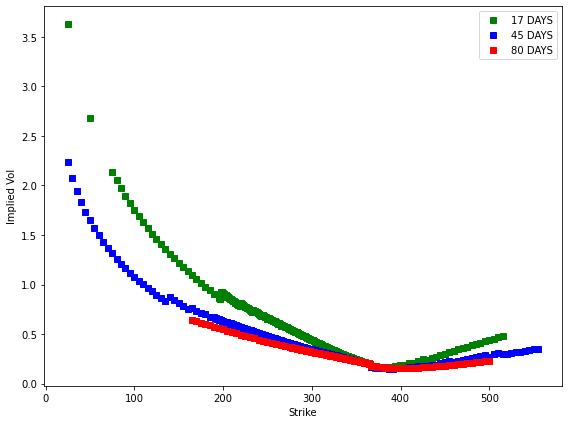

In [56]:
# Volatility smile for SPY market data

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_17["strike_price"], df_17["IV"], 'gs', label= "17 DAYS")
plt.plot(df_45["strike_price"], df_45["IV"], 'bs', label= "45 DAYS")
plt.plot(df_80["strike_price"], df_80["IV"], 'rs', label= "80 DAYS")
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()

## Diffused diffusion model calibration for SPY data

In [57]:
# calibration for T = 17

initialGuess = [0.1, 0.2]

res = least_squares(lambda x: diffusedcalibration(x,
                                             df_17["strike_price"],
                                             df_17["mid_price"],
                                             SPY_S,
                                             r_17,
                                             17/365,
                                             df_17["cp_flag"].values),
                    initialGuess)

s_ddm = res.x[0]
b_ddm = res.x[1]

print('Calibrated DDM model parameters: sigma = %.6f, beta = %.6f' % (s_ddm, b_ddm))

Calibrated DDM model parameters: sigma = 0.193812, beta = 0.164709


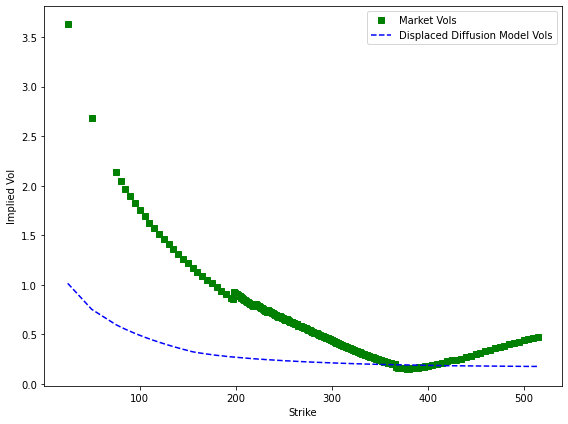

In [58]:
# vol smile for t = 17

ddmvols = []
for i in range(len(df_17)):
    
    if (df_17["cp_flag"][i] == "C"):
        price_ddm = DisplacedDiffusion_Call(SPY_S, df_17["strike_price"][i], r_17, s_ddm, T_17, b_ddm) 
        vol_ddm = impliedVolatility(SPY_S, df_17["strike_price"][i], r_17, price_ddm, T_17, "C")
        
    elif (df_17["cp_flag"][i] == "P"):
        price_ddm = DisplacedDiffusion_Put(SPY_S, df_17["strike_price"][i], r_17, s_ddm, T_17, b_ddm) 
        vol_ddm = impliedVolatility(SPY_S, df_17["strike_price"][i], r_17, price_ddm, T_17, "P")
        
    
    ddmvols.append(vol_ddm)

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_17["strike_price"], df_17["IV"], 'gs', label='Market Vols')
plt.plot(df_17["strike_price"], ddmvols, 'b--', label='Displaced Diffusion Model Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

In [59]:
# calibration for T = 45

initialGuess = [0.1, 0.2]

res = least_squares(lambda x: diffusedcalibration(x,
                                             df_45["strike_price"],
                                             df_45["mid_price"],
                                             SPY_S,
                                             r_45,
                                             45/365,
                                             df_45["cp_flag"].values),
                    initialGuess)

s_ddm = res.x[0]
b_ddm = res.x[1]

print('Calibrated DDM model parameters: sigma = %.6f, beta = %.6f' % (s_ddm, b_ddm))

Calibrated DDM model parameters: sigma = 0.194998, beta = 0.135367


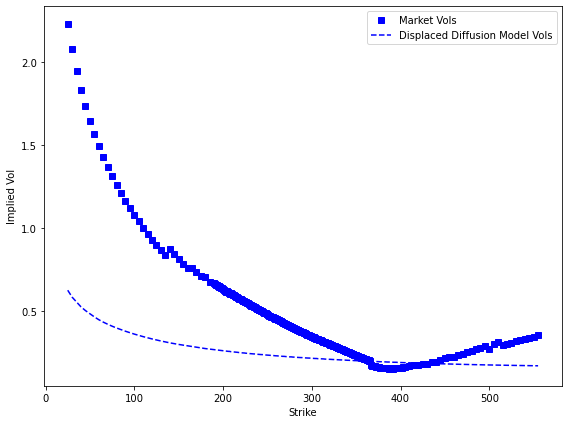

In [60]:
# vol smile for t = 45

ddmvols = []
for i in range(len(df_45)):
    
    if (df_45["cp_flag"][i] == "C"):
        price_ddm = DisplacedDiffusion_Call(SPY_S, df_45["strike_price"][i], r_45, s_ddm, T_45, b_ddm) 
        vol_ddm = impliedVolatility(SPY_S, df_45["strike_price"][i], r_45, price_ddm, T_45, "C")
        
    elif (df_45["cp_flag"][i] == "P"):
        price_ddm = DisplacedDiffusion_Put(SPY_S, df_45["strike_price"][i], r_45, s_ddm, T_45, b_ddm) 
        vol_ddm = impliedVolatility(SPY_S, df_45["strike_price"][i], r_45, price_ddm, T_45, "P")
        
    
    ddmvols.append(vol_ddm)

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_45["strike_price"], df_45["IV"], 'bs', label='Market Vols')
plt.plot(df_45["strike_price"], ddmvols, 'b--', label='Displaced Diffusion Model Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

In [61]:
# calibration for T = 80
initialGuess = [0.1, 0.2]

res = least_squares(lambda x: diffusedcalibration(x,
                                             df_80["strike_price"],
                                             df_80["mid_price"],
                                             SPY_S,
                                             r_80,
                                             80/365,
                                             df_80["cp_flag"].values),
                    initialGuess)

s_ddm = res.x[0]
b_ddm = res.x[1]

print('Calibrated DDM model parameters: sigma = %.6f, beta = %.6f' % (s_ddm, b_ddm))

Calibrated DDM model parameters: sigma = 0.203706, beta = 0.106547


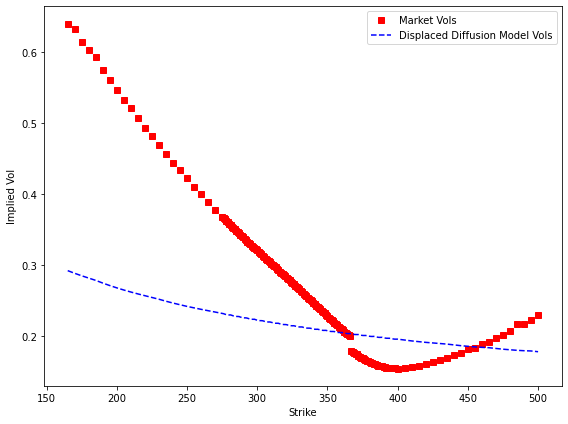

In [62]:
# vol smile for t = 80

ddmvols = []
for i in range(len(df_80)):
    
    if (df_80["cp_flag"][i] == "C"):
        price_ddm = DisplacedDiffusion_Call(SPY_S, df_80["strike_price"][i], r_80, s_ddm, T_80, b_ddm) 
        vol_ddm = impliedVolatility(SPY_S, df_80["strike_price"][i], r_80, price_ddm, T_80, "C")
        
    elif (df_80["cp_flag"][i] == "P"):
        price_ddm = DisplacedDiffusion_Put(SPY_S, df_80["strike_price"][i], r_80, s_ddm, T_80, b_ddm) 
        vol_ddm = impliedVolatility(SPY_S, df_80["strike_price"][i], r_80, price_ddm, T_80, "P")
        
    
    ddmvols.append(vol_ddm)

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_80["strike_price"], df_80["IV"], 'rs', label='Market Vols')
plt.plot(df_80["strike_price"], ddmvols, 'b--', label='Displaced Diffusion Model Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

## SABR model for SPY data

In [63]:
# calibration for T = 17
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_17.strike_price,
                                              df_17.IV,
                                              SPY_F17,
                                              T_17),
                    initialGuess)

In [64]:
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.651, beta = 0.7, rho = -0.409, nu = 5.318


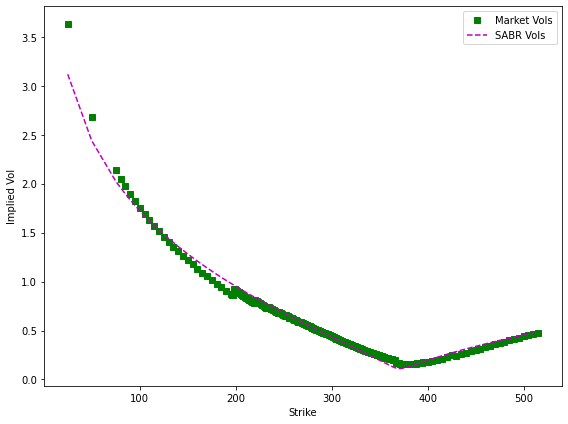

In [65]:
# vol smile for t = 17

sabrvols = []
for K in df_17.strike_price:
    sabrvols.append(SABR(SPY_F17, K, T_17, alpha, beta, rho, nu))

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_17.strike_price, df_17.IV, 'gs', label='Market Vols')
plt.plot(df_17.strike_price, sabrvols, 'm--', label='SABR Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

In [66]:
# calibration for T = 45
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_45.strike_price,
                                              df_45.IV,
                                              SPY_F45,
                                              T_45),
                    initialGuess)

In [67]:
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.899, beta = 0.7, rho = -0.486, nu = 2.763


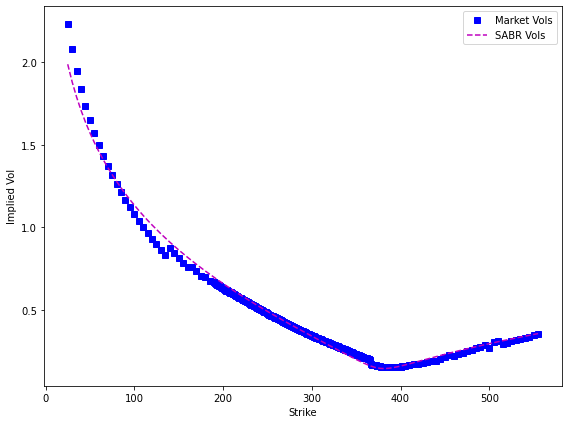

In [68]:
# vol smile for t = 45

sabrvols = []
for K in df_45.strike_price:
    sabrvols.append(SABR(SPY_F45, K, T_45, alpha, beta, rho, nu))

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_45.strike_price, df_45.IV, 'bs', label='Market Vols')
plt.plot(df_45.strike_price, sabrvols, 'm--', label='SABR Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()

In [69]:
# for T = 80
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_80.strike_price,
                                              df_80.IV,
                                              SPY_F80,
                                              T_80),
                    initialGuess)

/var/folders/d0/wlsqxrb928v8l7k86q57sjcr0000gn/T/ipykernel_75527/1833376684.py:14: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


In [70]:
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 1.119, beta = 0.7, rho = -0.631, nu = 1.752


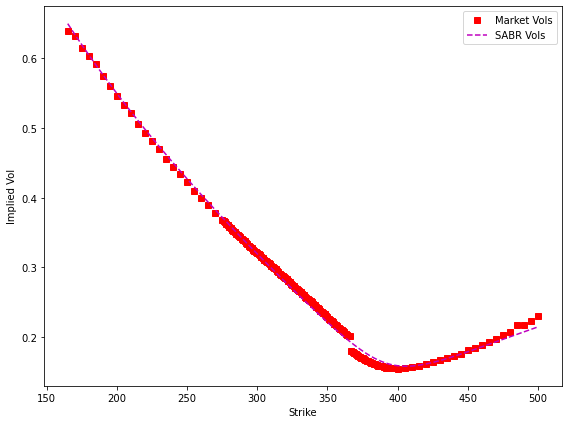

In [71]:
# vol smile for t = 80

sabrvols = []
for K in df_80.strike_price:
    sabrvols.append(SABR(SPY_F80, K, T_80, alpha, beta, rho, nu))

plt.figure(figsize = (8,6), tight_layout = True)
plt.plot(df_80.strike_price, df_80.IV, 'rs', label='Market Vols')
plt.plot(df_80.strike_price, sabrvols, 'm--', label='SABR Vols')
plt.ylabel("Implied Vol")
plt.xlabel("Strike")
plt.legend()
plt.show()